# DSCI 632 Final Project: Waste Classifier

**Ao Wang**

## Table of Content

* [Section 1: Define and describe the dataset](#Section-1:-Define-and-describe-the-dataset)
* [Section 2: Clean the data](#Section-2:-Clean-the-data)
* [Section 3: Transform the clean data](#Section-3:-Transform-the-clean-data)
* [Section 4: Show your analysis of the data](#Section-4:-Show-your-analysis-of-the-data)


# Section 1: Define and describe the dataset

* I chose the waste classification dataset on Kaggle: https://www.kaggle.com/datasets/techsash/waste-classification-data?datasetId=233210 because it seemed like a reliable data source with a usability score of 8.75. Additionally, it seemed like a large dataset, meaning the model could be more accurate and less prone to overfitting. And with the large size, I assumed I could use dataproc if the memory capacity exceeds the notebook's default.

* Since all the data are jpeg images, I'm using the pixels of each image as the features. The dataset is 446 MB and has training and testing data. Each folder has an organc folder and recyclible folder. I'm planning on preprocessing the images by resizing, reading them out as pixels, and normalizing the pixel values. Then do feature extraction by mapping each row to whether it's organic or not.

* I'm also taking a Deep Learning course along side this one, so I thought it would be pretty neat to create a binary classifier using PySpark's MultilayerPerceptronClassifier with the goal of predicting whether something is organic or recyclible.

## Libraries

In [34]:
from typing import Final, List
from os.path import join

from PIL import Image
import numpy as np
import pandas as pd

from google.cloud import storage

from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType, ArrayType
from pyspark.sql.functions import  udf, col, lit
from pyspark.ml.functions import array_to_vector
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

## Waste Images in GCP Bucket

I had to create a GCP Bucket to have a place to store the images and the notebooks. This notebook is currently being run on a dataproc cluster, following this tutorial: https://codelabs.developers.google.com/codelabs/spark-jupyter-dataproc#0. I ran this command to create the cluster

```bash
gcloud beta dataproc clusters create ${CLUSTER_NAME} \
--region=${REGION} \
--image-version=2.0-centos8 \
--master-machine-type=n1-standard-4 \
--worker-machine-type=n1-standard-4 \
--bucket=${BUCKET_NAME} \
--optional-components=JUPYTER \
--enable-component-gateway
```

The process was that I downloaded the images locally. Then in the terminal, I `cd` into the folder and ran `gcloud alpha storage cp -r . gs://${BUCKET_NAME}`. This quickly moved all images locally to the storage bucket in a few seconds. 



In [35]:
APP_NAME: Final[str] = "FINAL PROJECT"
BUCKET_NAME: Final[str] ="dsci-632-waste-images"
LINK: Final[str] = f"gs://{BUCKET_NAME}"
RESIZE: Final[int] = 32

In [36]:
spark: SparkSession = SparkSession\
.builder\
.appName(APP_NAME)\
.getOrCreate()

In [4]:
spark

## Loading in the Dataset

In [5]:
training_organic_folder: str = f"{LINK}/TRAIN/O"
training_recycle_folder: str = f"{LINK}/TRAIN/R"
testing_organic_folder: str = f"{LINK}/TEST/O"
testing_recycle_folder: str = f"{LINK}/TEST/R"

print(
    f"{training_organic_folder=}\n",
    f"{training_recycle_folder=}\n",
    f"{testing_organic_folder=}\n",
    f"{testing_recycle_folder=}\n",
)

training_organic_folder='gs://dsci-632-waste-images/TRAIN/O'
 training_recycle_folder='gs://dsci-632-waste-images/TRAIN/R'
 testing_organic_folder='gs://dsci-632-waste-images/TEST/O'
 testing_recycle_folder='gs://dsci-632-waste-images/TEST/R'



In [6]:
training_organic_sdf = spark.read.format("image").load(training_organic_folder)
training_recycle_sdf = spark.read.format("image").load(training_recycle_folder)
testing_organic_sdf  = spark.read.format("image").load(testing_organic_folder)
testing_recycle_sdf  = spark.read.format("image").load(testing_recycle_folder)

It's inconvenient how all the important data, like the width, height, mode, and image data is in one column. Later in the processing we'll extract the features we want.

In [7]:
training_organic_sdf.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [8]:
training_organic_sdf.show(5)

+--------------------+
|               image|
+--------------------+
|{gs://dsci-632-wa...|
|{gs://dsci-632-wa...|
|{gs://dsci-632-wa...|
|{gs://dsci-632-wa...|
|{gs://dsci-632-wa...|
+--------------------+
only showing top 5 rows



Let's take a look at an image, we see that these are pencil sharpenings, but they're too blue. The image datasource uses opencv to read the data. The library expects input as BGRA (Blue, Green, Red, Alpha) instead of RGB (Red, Green, Blue). So we need to fix that later in the data processing stage

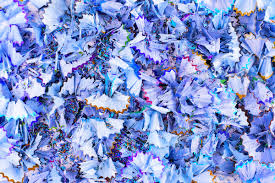

In [9]:
first_image_row = training_organic_sdf.take(10)[6]

first_img = Image.frombytes(
    mode="RGB", 
    data=bytes(first_image_row.image.data),
    size=[first_image_row.image.width, first_image_row.image.height]
)
first_img

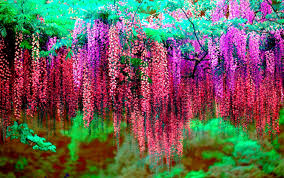

In [10]:
second_image_row = training_organic_sdf.take(10)[5]

second_img = Image.frombytes(
    mode="RGB", 
    data=bytes(second_image_row.image.data),
    size=[second_image_row.image.width, second_image_row.image.height]
)
second_img

Let's take a look at what each feature looks like, though we won't be using all of them. We'll only care about the height, width, and data of the image.

Additionally, we see that data is in hexidecimal, but I want it to be an array of pixel data.

In [11]:
training_organic_sdf.select(
    "image.origin",
    "image.height",
    "image.width",
    "image.nChannels",
    "image.mode",
    "image.data"
).show(5)

+--------------------+------+-----+---------+----+--------------------+
|              origin|height|width|nChannels|mode|                data|
+--------------------+------+-----+---------+----+--------------------+
|gs://dsci-632-was...|   225|  225|        3|  16|[04 00 08 00 88 0...|
|gs://dsci-632-was...|   168|  299|        3|  16|[BC B1 95 91 6F 6...|
|gs://dsci-632-was...|   188|  269|        3|  16|[74 B7 E8 7D BE E...|
|gs://dsci-632-was...|   208|  243|        3|  16|[25 39 98 27 41 A...|
|gs://dsci-632-was...|   159|  318|        3|  16|[12 20 14 0E 26 0...|
+--------------------+------+-----+---------+----+--------------------+
only showing top 5 rows



# Section 2: Clean the data

In terms of cleaning, we saw before how the images had a format of BGR (Blue, Green, Red). So we have to change the color format to the RGB (Red, Green, Blue) color format. We just reverse the ordering. 

In [40]:
def convert_bgr_array_to_rgb_array(img_array: np.ndarray) -> np.ndarray:
    return img_array[..., ::-1]

(183, 275, 3)


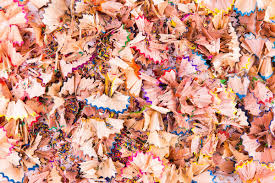

In [13]:
converted_img_array = convert_bgr_array_to_rgb_array(np.asarray(first_img))
print(converted_img_array.shape)
Image.fromarray(converted_img_array).show()

(178, 284, 3)


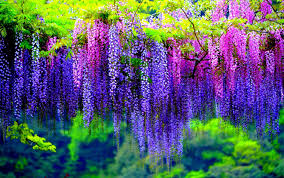

In [14]:
converted_img_array = convert_bgr_array_to_rgb_array(np.asarray(second_img))
print(converted_img_array.shape)
Image.fromarray(converted_img_array).show()

## Resizing Image
The function converts the image binary into a numpy array. It then reshapes the array into 64 by 64 pixels, keeping its RGB value, and flattens it to become a row in the spark dataframe

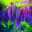

In [16]:
Image.fromarray(converted_img_array).resize((RESIZE, RESIZE))

In [17]:
def transform_image(data: bytearray, height: int, width: int) -> List[float]:
    img = Image.frombytes(
        mode="RGB", 
        data=bytes(data),
        size=[width, height]
    )\
    .resize((RESIZE, RESIZE))\
    .convert("RGB")    
    img = convert_bgr_array_to_rgb_array(np.asarray(img))
    img = np.array(img) / 255.0
    return img.flatten().tolist()

In [18]:
resize_img_udf = udf(transform_image, ArrayType(elementType=FloatType()))

Below we process all the training and testing data for organic and recyclibles. 

In [19]:
processed_training_organic_sdf = training_organic_sdf\
.withColumn(
    "resized_image",
    resize_img_udf(
        training_organic_sdf["image.data"],
        training_organic_sdf["image.height"],
        training_organic_sdf["image.width"]
    )
)\
.withColumn("label", lit(1))

processed_testing_organic_sdf = testing_organic_sdf\
.withColumn(
    "resized_image",
    resize_img_udf(
        testing_organic_sdf["image.data"],
        testing_organic_sdf["image.height"],
        testing_organic_sdf["image.width"]
    )
)\
.withColumn("label", lit(1))

processed_training_recycle_sdf = training_recycle_sdf\
.withColumn(
    "resized_image",
    resize_img_udf(
        training_recycle_sdf["image.data"],
        training_recycle_sdf["image.height"],
        training_recycle_sdf["image.width"]
    )
)\
.withColumn("label", lit(0))

processed_testing_recycle_sdf = testing_recycle_sdf\
.withColumn(
    "resized_image",
    resize_img_udf(
        testing_recycle_sdf["image.data"],
        testing_recycle_sdf["image.height"],
        testing_recycle_sdf["image.width"]
    )
)\
.withColumn("label", lit(0))

In [20]:
processed_training_organic_sdf.select("image.origin").first()

Row(origin='gs://dsci-632-waste-images/TRAIN/O/O_8490.jpg')

In [21]:
processed_testing_organic_sdf.select("image.origin").first()

Row(origin='gs://dsci-632-waste-images/TEST/O/O_13418.jpg')

In [22]:
processed_training_recycle_sdf.select("image.origin").first()

Row(origin='gs://dsci-632-waste-images/TRAIN/R/R_4801.jpg')

In [23]:
processed_testing_recycle_sdf.select("image.origin").first()

Row(origin='gs://dsci-632-waste-images/TEST/R/R_11111.jpg')

# Section 3: Transform the clean data
We then merge all the data because we'll use PySpark's randomSplit to separate the training and testing data ourselves. Then we convert the array of floats that's the `resized_image` column and we turn it into a vector. Then we do a 70/30 split for training and testing data.

In [24]:
stacked_df = processed_training_organic_sdf\
.union(processed_training_recycle_sdf)\
.union(processed_testing_organic_sdf)\
.union(processed_testing_recycle_sdf)

In [25]:
stacked_df.show()

+--------------------+--------------------+-----+
|               image|       resized_image|label|
+--------------------+--------------------+-----+
|{gs://dsci-632-wa...|[0.11372549, 0.53...|    1|
|{gs://dsci-632-wa...|[0.4392157, 0.360...|    1|
|{gs://dsci-632-wa...|[0.9137255, 0.772...|    1|
|{gs://dsci-632-wa...|[0.5176471, 0.274...|    1|
|{gs://dsci-632-wa...|[0.3529412, 0.301...|    1|
|{gs://dsci-632-wa...|[0.37254903, 0.78...|    1|
|{gs://dsci-632-wa...|[0.98039216, 0.86...|    1|
|{gs://dsci-632-wa...|[0.6313726, 0.647...|    1|
|{gs://dsci-632-wa...|[0.8, 0.38039216,...|    1|
|{gs://dsci-632-wa...|[0.61960787, 0.47...|    1|
|{gs://dsci-632-wa...|[0.4392157, 0.415...|    1|
|{gs://dsci-632-wa...|[0.39607844, 0.71...|    1|
|{gs://dsci-632-wa...|[0.62352943, 0.65...|    1|
|{gs://dsci-632-wa...|[0.92156863, 0.77...|    1|
|{gs://dsci-632-wa...|[0.81960785, 0.40...|    1|
|{gs://dsci-632-wa...|[0.015686275, 0.0...|    1|
|{gs://dsci-632-wa...|[0.43529412, 0.32...|    1|


In [26]:
stacked_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- resized_image: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- label: integer (nullable = false)



In [27]:
stacked_df.count()

25077

In [28]:
vectorized_stacked_sdf = stacked_df.withColumn("features", array_to_vector(col("resized_image")))

In [29]:
vectorized_stacked_sdf.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- resized_image: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- label: integer (nullable = false)
 |-- features: vector (nullable = true)



In [30]:
train_df, test_df = vectorized_stacked_sdf\
.select("label", "features")\
.randomSplit([0.7, 0.3], 1)

# Section 4: Show your analysis of the data
For the layers, there are initially 32 x 32 x 3 nodes because the images are changed to 32 by 32 pixels with 3 values determining the color for each pixel (RBG). Then the number of nodes for the hidden layers should always be values between the current number of features and the number of target values, which is 2. 

In [31]:
layers = [RESIZE * RESIZE * 3, 128, 32, 2]

In [ ]:
mlpc = MultilayerPerceptronClassifier(
    featuresCol="features",
    labelCol="label",
    layers=layers,  # Increased the number of neurons in hidden layers
    maxIter=100,    # Reduced the number of iterations to avoid overfitting
    blockSize=128,  # Increased blockSize for efficient training
    seed=1,         # Changed the seed for reproducibility
    solver="l-bfgs" # Changed the solver to 'l-bfgs' for better convergence
)
ann = mlpc.fit(train_df)

An **F1 score** of **0.8081733675692643** for the binary classifier shows the model is relatively good at balancing precision and recall. It means that the classifier is effective at both minimizing false positives (good precision) and capturing a significant portion of the positive instances (good recall).

The F1 score is a metric commonly used to assess the performance of binary classifiers, mainly to check the imbalance between the two classes.

However, higher F1 scores are desirable, but the ideal F1 score can vary depending on the domain and the trade-offs between precision and recall that are acceptable for our specific usecases.

In [ ]:
pred = ann.transform(test_df)
evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)
ann_f1 = evaluator.evaluate(pred)
ann_f1

23/09/03 00:14:44 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB


0.8081733675692643

All in all, the classifier could be better if there were more data. Perhaps I could rotate the images by 90 degrees and double the dataset. Or I could increase the number of epochs, make it run longer. Or resize the images larger than 32 by 32 pixels. There are a lot of factors that could help improve this model.

In [49]:
ann.save(f"{LINK}/waste-classifier-ann")

23/09/03 00:44:39 WARN org.apache.spark.scheduler.TaskSetManager: Stage 265 contains a task of very large size (3223 KiB). The maximum recommended task size is 1000 KiB.
